In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import pandas_ta as ta
import pytz
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.requests import StockLatestBarRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.timeframe import TimeFrameUnit
from datetime import time
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
%matplotlib inline

In [139]:
load_dotenv("../environment.env")

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret = os.getenv("ALPACA_SECRET")
alpaca_base_url = os.getenv("ALPACA_BASE_URL")

In [140]:
# Function to start up the main client for retrieving data
def setup_historical_client(key_: str,secret_: str, base_url_: str, raw_data_: bool):
    return StockHistoricalDataClient(
        api_key=key_, 
        secret_key=secret_, 
        raw_data=raw_data_
    )

# Function to retrieve the latest bars 
def retrieve_stock_bars(client_: StockHistoricalDataClient, symbol_: str, time_interval_: int, time_unit_: TimeFrameUnit, limit_: int):
    # Get ET and UTC time zones
    eastern = pytz.timezone("America/New_York")
    utc = pytz.UTC
    # Get current time and calculate start and end time for StockBarsRequest by calculating ET then converting to UTC
    now_et = datetime.now(eastern) 
    start_et = (now_et - timedelta(days=10)).replace(hour=0, minute=0, second=0, microsecond=0)
    end_et = (now_et + timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    start_utc = start_et.astimezone(utc)
    end_utc = end_et.astimezone(utc)
    prev_stock_bar_params = StockBarsRequest(
        symbol_or_symbols=symbol_,
        start=start_utc,
        end=end_utc,
        timeframe=TimeFrame(
            amount=time_interval_,
            unit=time_unit_),
        limit=limit_,
        feed="iex",
        sort="desc"
    )
    return client_.get_stock_bars(request_params=prev_stock_bar_params)

# Function to retrieve the single latest bar 
def retrieve_latest(client_: StockHistoricalDataClient, symbol_: str):
    latest_params = StockLatestBarRequest(symbol_or_symbols=symbol_)
    return client_.get_stock_latest_bar(request_params=latest_params)

# Function to convert raw bar data to an easy to parse dataframe
def data_frame_from_stock_bars(data_: dict):
    ticker, bars = next(iter(data_.items()))

    if not bars:
        raise ValueError(f"No data retrieved for ticker: {ticker}")
    
    df = pd.DataFrame(bars) # Create data frame from raw data
    df.rename(columns={'o':'open', 'h':'high','l':'low','c':'close','v':'volume','t':'timestamp'}, inplace=True) # Rename columns
    df['timestamp'] = pd.to_datetime(df['timestamp']) # Set time stamp to type datetime
    df.set_index('timestamp', inplace=True) # Index using time stamp
    eastern_time_zone = pytz.timezone("America/New_York") # Create ET timezone 
    df.index = df.index.tz_convert(eastern_time_zone) # Convert data frame times from UTC to ET 

    df['market_status'] = df.index.map(classify_market_status) # Use helper function to get market status

    return df[['close','high','low','open','volume', 'market_status']]

# Helper function used to classify market status in dataframe
def classify_market_status(dt: pd.Timestamp) -> str:
    t = dt.time()
    if time(4, 0) <= t < time(9, 30):
        return "pre-market"
    elif time(9, 30) <= t < time(16, 0):
        return "regular"
    elif time(16, 0) <= t < time(20, 0):
        return "after-hours"
    else:
        return "closed"

def filter_regular_hours(data_: pd.DataFrame) -> pd.DataFrame: 
    return data_[data_["market_status"] == "regular"]

def add_technical_indicators(data_: pd.DataFrame) -> pd.DataFrame:
    data_ = data_.sort_index()
    data_['ATR'] = data_.ta.atr(length=20) # Average True Range for 20 candlesticks
    data_['RSI'] = data_.ta.rsi() # Relative Strength Index
    data_['MA40'] = data_.ta.sma(length=40) # Moving Average for 40 candlesticks
    data_['MA80'] = data_.ta.sma(length=80) # Moving Average for 80 candlesticks
    data_['MA160'] = data_.ta.sma(length=160) # Moving Average for 160 candlesticks
    return data_

# Creates target variable for ML prediction
# New column "Higher/Lower" indicates whether the NEXT candlestick's open price
# will be higher (1), lower (-1), or same (0) than the CURRENT close price
# Note: Data is sorted chronologically (oldest first) to ensure proper time sequence
def classify_price_gap(data_: pd.DataFrame) -> pd.DataFrame:
    data_ = data_.copy()
    # Sort by timestamp to ensure chronological order (oldest first)
    data_ = data_.sort_index()
    
    # Calculate whether the NEXT candlestick's open is higher/lower than CURRENT close
    # This creates a target variable for ML prediction
    data_['next_open_vs_current_close'] = data_['open'].shift(-1) - data_['close']
    data_['Higher/Lower'] = data_['next_open_vs_current_close'].apply(
        lambda x: -1 if x < 0 else (1 if x > 0 else 0)
    )
    # Drop the last row since we can't predict the next candlestick for it
    # data_ = data_.dropna()
    return data_

In [141]:
class Net(nn.Module):
    def __init__(self, in_features=10, hl1=10, hl2=10, out_features=2):  # Changed to 2 for binary classification
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=hl1)
        self.fc2 = nn.Linear(in_features=hl1, out_features=hl2)
        self.out = nn.Linear(in_features=hl2, out_features=out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x

In [142]:
# Create Neural Network Object
Net = Net()

In [143]:
# Load data for training
# Use dataframe

client = setup_historical_client(ALPACA_API_KEY, ALPACA_SECRET, ALPACA_BASE_URL, raw_data_=True)
raw_data = retrieve_stock_bars(client, "AAPL", 1, TimeFrameUnit.Minute, 10000)
raw_data_frame = data_frame_from_stock_bars(raw_data)
filtered_hours_data = filter_regular_hours(raw_data_frame)
technical_indicators_data = add_technical_indicators(filtered_hours_data)
price_gap_data = classify_price_gap(technical_indicators_data)
clean_data = price_gap_data.dropna()  # Remove NaN
clean_data = clean_data[clean_data['Higher/Lower'] != 0]
X = clean_data[['close', 'high', 'low', 'open', 'volume', 'ATR', 'RSI', 'MA40', 'MA80', 'MA160']]
y = clean_data['Higher/Lower']
print(clean_data)

                             close     high      low    open  volume  \
timestamp                                                              
2025-08-29 12:09:00-04:00  232.090  232.180  232.080  232.09    3612   
2025-08-29 12:10:00-04:00  232.160  232.190  232.060  232.06    5933   
2025-08-29 12:11:00-04:00  232.230  232.290  232.170  232.18    3016   
2025-08-29 12:12:00-04:00  232.270  232.270  232.220  232.22    1961   
2025-08-29 12:14:00-04:00  232.370  232.370  232.290  232.36    3161   
...                            ...      ...      ...     ...     ...   
2025-09-08 10:56:00-04:00  239.200  239.205  239.150  239.19    4550   
2025-09-08 10:57:00-04:00  239.220  239.280  239.215  239.24    2511   
2025-09-08 10:58:00-04:00  239.170  239.210  239.135  239.16    2226   
2025-09-08 10:59:00-04:00  239.150  239.170  239.120  239.16    3702   
2025-09-08 11:00:00-04:00  239.235  239.255  239.110  239.13    4890   

                          market_status       ATR        RSI   

In [117]:
# Set up data for training
X = clean_data[['close', 'high', 'low', 'open', 'volume', 'ATR', 'RSI', 'MA40', 'MA80', 'MA160']]
y = clean_data['Higher/Lower']
X = X.values
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# Convert data to torch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert targets from -1/1 to 0/1 for CrossEntropyLoss
y_train = torch.LongTensor((y_train + 1) // 2)  # -1 becomes 0, 1 becomes 1
y_test = torch.LongTensor((y_test + 1) // 2)    # -1 becomes 0, 1 becomes 1

In [119]:
# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.01)

In [120]:
# Focus on training the network - epochs and losses
loses = []
epochs = 100
for epoch in range(epochs):
    # Forward pass
    y_pred = Net.forward(X_train)
    # Calculate loss
    loss = criterion(y_pred, y_train)

    # Save loss
    loses.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss.item()}")

Epoch 0 loss: 64.13654327392578
Epoch 10 loss: 8.064942359924316
Epoch 20 loss: 3.3307368755340576
Epoch 30 loss: 1.602264165878296
Epoch 40 loss: 1.1477782726287842
Epoch 50 loss: 0.7751331329345703
Epoch 60 loss: 0.7347724437713623
Epoch 70 loss: 0.7214582562446594
Epoch 80 loss: 0.7004773616790771
Epoch 90 loss: 0.6941843628883362


Text(0.5, 0, 'Epoch')

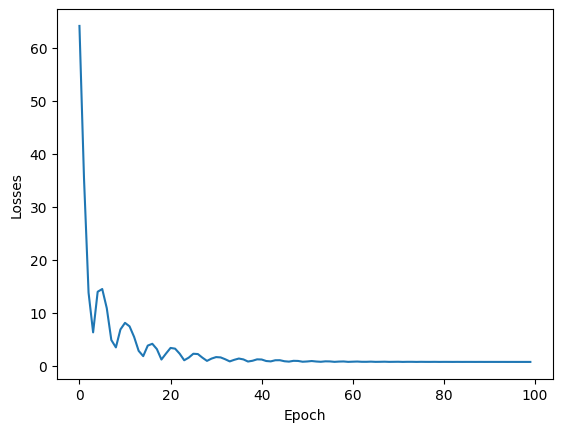

In [121]:
plt.plot(range(epochs), loses)
plt.ylabel("Losses")
plt.xlabel("Epoch")

In [123]:
# Evaluate Model on Test Data 
with torch.no_grad():
    y_eval = Net.forward(X_test) # Get y_eval on test data
    loss = criterion(y_eval, y_test) # Get loss 


In [131]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = Net.forward(data)

        print(f'{i+1}: {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'Correct: {correct}')

1: tensor([15.3029, 15.4201]) 	 0 	 1
2: tensor([ 0.1966, -0.1987]) 	 1 	 0
3: tensor([5.4227, 5.5929]) 	 1 	 1
4: tensor([53.8649, 54.1121]) 	 1 	 1
5: tensor([46.9676, 47.1441]) 	 1 	 1
6: tensor([ 0.1966, -0.1987]) 	 0 	 0
7: tensor([2.6960, 2.7919]) 	 1 	 1
8: tensor([ 0.1966, -0.1987]) 	 1 	 0
9: tensor([1.5686, 1.5298]) 	 1 	 0
10: tensor([ 0.1966, -0.1987]) 	 0 	 0
11: tensor([28.4222, 28.6034]) 	 1 	 1
12: tensor([ 0.1966, -0.1987]) 	 0 	 0
13: tensor([6.2870, 6.4226]) 	 0 	 1
14: tensor([ 0.1966, -0.1987]) 	 0 	 0
15: tensor([26.2555, 26.5036]) 	 1 	 1
16: tensor([4.4177, 4.6497]) 	 0 	 1
17: tensor([ 0.3898, -0.8173]) 	 1 	 0
18: tensor([2.7392, 2.8789]) 	 0 	 1
19: tensor([ 0.1966, -0.1987]) 	 1 	 0
20: tensor([0.7034, 0.4904]) 	 0 	 0
21: tensor([ 0.1966, -0.1987]) 	 0 	 0
22: tensor([15.4204, 15.5521]) 	 0 	 1
23: tensor([19.6900, 19.8435]) 	 1 	 1
24: tensor([ 0.1966, -0.1987]) 	 0 	 0
25: tensor([1.1035, 0.9917]) 	 1 	 0
26: tensor([ 0.1966, -0.1987]) 	 0 	 0
27: tensor(